In [1]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns

from astropy import units as u
from astropy import constants as c

%matplotlib inline

In [2]:
sns.set_style('darkgrid')

## Constants

In [4]:
# cgs units
solMass   = (1 * u.solMass).cgs.value
jupMass   = (2 * u.jupiterMass).cgs.value
earthMass = (1 * u.earthMass).cgs.value
G         = (1 * c.G).cgs.value
AU        = (1 * u.au).cgs.value
year      = (1 * u.year).cgs.value
day       = (1 * u.day).cgs.value
earth_v   = (30 * u.km/u.s).value
moon_v    = (1 * u.km/u.s).cgs.value

## Derivatives

Calculates velocity and acceleration on $m_i$ due to $m_j$ and $m_k$

In [5]:
def sho_func(t, uin_i, m_j, uin_j, m_k, uin_k):
    # position and velocity
    r_i = uin_i[:2]
    v_i = uin_i[2:]
    
    r_j = uin_j[:2]
    r_k = uin_k[:2] 
    # position vector pointing from one of the two masses to m_i
    d_ij = np.linalg.norm(r_j - r_i)
    d_ik = np.linalg.norm(r_k - r_i)

    # calulating accelerations
    g = (G*m_j/d_ij**3) * (r_j - r_i) + (G*m_k/d_ik**3) * (r_k - r_i)
    
    derivs = np.ndarray(4)
    derivs[:2] = v_i
    derivs[2:] = g
    
    return derivs

## Integrator

In [6]:
def sho_RK4(t, uold_i, m_j, uold_j, m_k, uold_k, dt):
    K1 = sho_func(t, uold_i, m_j, uold_j, m_k, uold_k)
    K2 = sho_func(t + dt/2, uold_i + K1*dt/2, m_j, uold_j, m_k, uold_k)
    K3 = sho_func(t + dt/2, uold_i + K2*dt/2, m_j, uold_j, m_k, uold_k)
    K4 = sho_func(t + dt, uold_i + K3*dt, m_j, uold_j, m_k, uold_k)
    
    unew_i = uold_i + (dt/6)*(K1 + 2*(K2 + K3) + K4)
    return unew_i

## Run Simulation

integrate orbit and return positions and velocities, all in cgs

Inputs:
* $q \equiv m_3 / m_2$
* host_mass: mass of host star, located at origin
* secondary_mass: mass of hot jupiter
* scndry_x: x position of secondary, relative to origin (host star)
* cmpn_x: x positon of companion to secondary, relative to secondary x
* cmpn_y: same for y positions
* cmpn_vy: y component of companion velocity, relative to secondary's velocity in the y
* t_frac: raction of the orbital period of secondary, in absence on the companion, that the simulation will run up to
* f: fudge factor for adaptive timestep procedure, where $dt = 10^f\ r_0 / v_0$,
with $r_0$ being the distance of the companion from the secondary at the beginning of the timestep and $v_0$ being its absolute speed at the beginning of the timestep

Outputs:
* mi_coords: a (number of timesteps) $\times$ (4) array, where the 4 columns are x_i, y_i, vx_i, and vy_i, respectively for the ith object. In this run,
* i = 1: primary
* i = 2: secondary
* i = 3: companion

In [93]:
def run_orb(q, host_mass, scndry_mass, scndry_x, \
            cmpn_x, cmpn_y, cmpn_vy, t_frac, f):
    m_1 = host_mass # host star
    m_2 = scndry_mass #m_1 / 5000 # hot jupiter
    m_3 = q * m_2  # companion

    # m1: primary
    x_1  =  0.0
    y_1  =  0.0
    vx_1 =  0.0
    vy_1 =  0.0

    # m2: secondary
    x_2  = scndry_x
    y_2  = 0.0
    vx_2 =  0.0
    vy_2 = -np.sqrt(G*m_1/np.abs(x_2))

    # m3: companion (values relative to secondary)
    x_3  = x_2 + cmpn_x 
    y_3  = y_2 + cmpn_y
    vx_3 =  0.0
    vy_3 = vy_2 + cmpn_vy 

    # characteristic timescale set by secondary's orbital timescale
    T0 = 2*np.pi*np.sqrt(np.abs(x_2)**3/(G*m_1))
    tmax  = t_frac * T0

    uold_1 = np.array( [x_1, y_1, vx_1, vy_1] )
    uold_2 = np.array( [x_2, y_2, vx_2, vy_2] )
    uold_3 = np.array( [x_3, y_3, vx_3, vy_3] )

    m1_coord = uold_1
    m2_coord = uold_2
    m3_coord = uold_3

    # r0, v0 based on speed at beginning of first timestep
    # use prescription inside while loop below for adaptive time-stepping
    r0 = np.sqrt( (uold_3[0] - uold_2[0])**2 + (uold_3[1] - uold_2[1])**2 )
    v0 = np.sqrt(uold_3[2]**2 + uold_3[3]**2) 
    dt = 10**(f) * r0 / v0
    
    t = 0
    while (t <= tmax):
        # r0, v0 based on speed at beginning of current timestep
        #r0 = np.sqrt( (uold_3[0] - uold_2[0])**2 + (uold_3[1] - uold_2[1])**2 )
        #v0 = np.sqrt(uold_3[2]**2 + uold_3[3]**2) 
        #dt = 10**(f) * r0 / v0

        unew_1 = sho_RK4(t, uold_1, m_2, uold_2, m_3, uold_3, dt) # sun
        unew_2 = sho_RK4(t, uold_2, m_1, uold_1, m_3, uold_3, dt) # earth
        unew_3 = sho_RK4(t, uold_3, m_1, uold_1, m_2, uold_2, dt) # moon

        m1_coord = np.vstack( (m1_coord, unew_1) )
        m2_coord = np.vstack( (m2_coord, unew_2) )
        m3_coord = np.vstack( (m3_coord, unew_3) )

        # step forward
        uold_1 = unew_1 
        uold_2 = unew_2
        uold_3 = unew_3
        t += dt
    
    return m1_coord, m2_coord, m3_coord

## Get results from `run_orb`

In [89]:
# mass ratio
q              = 0.001
# primary
host_mass      = solMass
# secondary
scndry_mass = jupMass
scndry_x       = -0.02*AU
# companion
cmpn_x         = 0.00 * AU
cmpn_y         = 0.005 * AU
cmpn_vy        = moon_v
# time options
t_frac         = 5
f              = -2
# run simulation
m1_coord, m2_coord, m3_coord = run_orb(q, host_mass, secondary_mass, scndry_x, \
            cmpn_x, cmpn_y, cmpn_vy, t_frac, f)

## Plot results

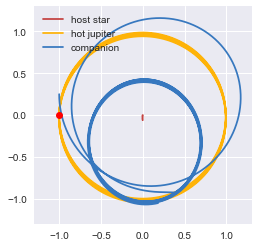

In [90]:
fig, ax = plt.subplots(1,1)

colors = ["reddish", "amber", "windows blue"]#, "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))

ax.set_aspect("equal")

L = np.abs(m2_coord[0][0])

x_1 = m1_coord[:,0] / L
y_1 = m1_coord[:,1] / L
x_2 = m2_coord[:,0] / L
y_2 = m2_coord[:,1] / L
x_3 = m3_coord[:,0] / L
y_3 = m3_coord[:,1] / L

ax.plot(x_1, y_1, label='host star')
ax.plot(x_2, y_2, label='hot jupiter')
ax.plot(x_3, y_3, label='companion')
ax.plot(x_2[0], y_2[0], 'ro')

#ax.plot(x_3[100]/AU, y_3[100]/AU, 'ro')

lim = 1.3*np.abs(x_2[0])
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.legend(loc='best')

plt.show()

# Animate

In [64]:
from matplotlib import animation, rc
from IPython.display import HTML

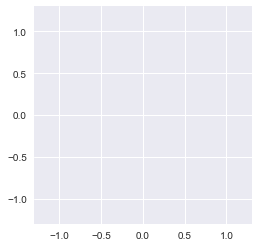

In [96]:
fig, ax = plt.subplots()

lim = 1.3*np.abs(x_2[0])
ax.set_xlim((-lim, lim))
ax.set_ylim((-lim, lim))
ax.set_aspect("equal")

line, = ax.plot([], [], lw=2) # secondary
line2, = ax.plot([], [], lw=2)
line3, = ax.plot([], [], lw=2)
line4, = ax.plot([], [], lw=2) # primary
line5, = ax.plot([], [], lw=2)
line6, = ax.plot([], [], lw=2)

line = [line, line2, line3, line4, line5, line6]

nstep = 50 # sample every n steps
x_2_downsamp = x_2[::nstep]
y_2_downsamp = y_2[::nstep]
x_3_downsamp = x_3[::nstep]
y_3_downsamp = y_3[::nstep]

# initialization function: plot the background of each frame
def init():
    # secondary
    line[0].set_data([], [])
    line[1].set_data([], [])
    line[2].set_data([], [])
    
    # companion
    line[3].set_data([], [])
    line[4].set_data([], [])
    line[5].set_data([], [])
    return line

# animation function. This is called sequentially
def animate(i):
    # secondary
    # plot the trajectory
    line[0].set_data(x_2_downsamp[:i+1], y_2_downsamp[:i+1]) 
    # the +1 makes it inclusive
    line[0].set_color('orange')  
    # add a point at the beginning
    line[1].set_data(x_2_downsamp[0], y_2_downsamp[0])
    line[1].set_marker('o')
    line[1].set_color('g')    
    # add a point at the end
    line[2].set_data(x_2_downsamp[i], y_2_downsamp[i])
    line[2].set_marker('o')
    line[2].set_color('r')
        
    # companion
    # plot the trajectory
    line[3].set_data(x_3_downsamp[:i+1], y_3_downsamp[:i+1]) 
    # the +1 makes it inclusive
    line[3].set_color('b')
    # add a point at the beginning
    line[4].set_data(x_3_downsamp[0], y_3_downsamp[0])
    line[4].set_marker('o')
    line[4].set_color('g')    
    # add a point at the end
    line[5].set_data(x_3_downsamp[i], y_3_downsamp[i])
    line[5].set_marker('o')
    line[5].set_color('r')
    
    return line

In [97]:
# call the animator. blit=True re-draws just the parts that have 
# changed to make things a bit faster

# remove white margin
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, 
                    wspace=None, hspace=None)
N = len(x_2_downsamp)
anim = animation.FuncAnimation(fig, animate, frames=N, init_func=init, interval=50, \
                               blit=True)
HTML(anim.to_html5_video())